In [1]:
import dask.dataframe as dd
import pandas as pd
import os
import csv
import traceback
import logging
import numpy as np
import geopandas as gp
arrival_count_map = {}
inter_arrival_map = {}
with open("/home/blakemoss/911_modeling/data_retrieval/911_data_sources.csv") as source_csv:
    dataset_path = "/home/blakemoss/911_modeling/data_retrieval/csvs/"
    reader = csv.DictReader(source_csv)
    a = 0
    for row in reader:
        try:
            if row["Saved File Name"] != "" and row["Unique ID"] != "" and "N/A" not in row["Assigned Timestamp"]:
                filename = row['Saved File Name']
                if "boulder" not in filename:
                    c = row["Assigned Timestamp"].lower()
                else:
                    c = row["Assigned Timestamp"]
                path = "{}{}".format(dataset_path, filename)
                unique_id = row["Unique ID"]
                columns = [unique_id, c]
                if "sf" in filename:
                    df = dd.read_csv(path, usecols=columns, error_bad_lines=False, engine="python", dtype={unique_id:object})
                    df = df.drop_duplicates(subset=unique_id)
                else:
                    df = dd.read_csv(path, usecols=columns, dtype={unique_id:object})
                print("Loaded {}".format(filename), flush=True)
                df[c] = dd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
                df = df.dropna()
                df = df.compute()
                df = df.sort_values(by=c,ascending=True)
                df['delta'] = (df[c]-df[c].shift()).dt.seconds.fillna(np.float64(0))
                df = df[df['delta']!= np.float64(0)]
                df.index = df[c]
                print(df[df['delta']==0])
                day_watch = df.between_time('07:00','15:00')
                swing_watch = df.between_time('15:00','23:00')
                midnight_watch = df.between_time('23:00','07:00')
                midnight_group = midnight_watch.groupby([midnight_watch.index.year, midnight_watch.index.month, midnight_watch.index.day, midnight_watch.index.hour])[unique_id].count()
                day_group = day_watch.groupby([day_watch.index.year, day_watch.index.month, day_watch.index.day, day_watch.index.hour])[unique_id].count()
                swing_group = swing_watch.groupby([swing_watch.index.year, swing_watch.index.month, swing_watch.index.day, swing_watch.index.hour])[unique_id].count()
                total_arrival_counts = df.groupby([df.index.year, df.index.month, df.index.day, df.index.hour])[unique_id].count()
                arrival_count_map[filename] = {"day (7AM-3PM)": day_group.values, "swing (3PM-11:PM)": swing_group.values, "midnight (11PM-7AM)": midnight_group.values, "All": total_arrival_counts.values}
                inter_arrival_map[filename] = {"day (7AM-3PM)": day_watch['delta'].values, "swing (3PM-11:PM)": swing_watch['delta'].values, "midnight (11PM-7AM)": midnight_watch['delta'].values, "All": df['delta'].values}
                a += len(df[unique_id])


        except Exception as e:
            logging.error(traceback.format_exc())
    print(a) 


Loaded boulder_fire_rescue_2019.csv
Empty DataFrame
Columns: [MASTERINCIDENTNUMBER, TIMEFIRSTUNITASSIGNED, delta]
Index: []
Loaded richmond_pd_2018.csv
Empty DataFrame
Columns: [cfsid, dispatchtime, delta]
Index: []
Loaded sf_fire_2019.csv


Skipping line 147495: unexpected end of data
Skipping line 148985: unexpected end of data


Empty DataFrame
Columns: [call_number, dispatch_dttm, delta]
Index: []
Loaded cin_pd_2019.csv
Empty DataFrame
Columns: [event_number, dispatch_time_primary_unit, delta]
Index: []
Loaded no_pd_2019.csv
Empty DataFrame
Columns: [nopd_item, timedispatch, delta]
Index: []
Loaded nyc_ems_2019.csv
Empty DataFrame
Columns: [cad_incident_id, first_assignment_datetime, delta]
Index: []
Loaded nyc_fd_2018.csv
Empty DataFrame
Columns: [starfire_incident_id, first_assignment_datetime, delta]
Index: []
3109215


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [3]:
def plot_arrival_histogram(name, obj):
    for shift, count in obj.items():
        p = st.poisson(np.mean(count))
        fig, ax = plt.subplots()
        t = [x for x in range(int(max(count)))]
        density = True
        n, bins, patches = ax.hist(count, bins=len(t), density=density)
        x = [a for a in range(int(bins[-1]))]
        ax.plot(x,p.pmf(x),'k')
        ax.set_title("Arrival Count Histogram {}, {} ({})".format(name, shift, np.mean(count)))
        ax.set_xlabel("# of Incidents Assigned to Unit(s) Dispatch in an Hour (Bucket)")
        if density is True:
            ax.set_ylabel("Probability")
        else:
            ax.set_ylabel("Frequency")
        
def plot_interarrival_histogram(name, obj):
    for shift, count in obj.items():
        e = st.expon
        args = e.fit(count)
        t = [x for x in range(int(max(count)))]
        #t = st.iqr(count)
        #print(t)
        density = True
        fig, ax = plt.subplots()
        #ax.boxplot(count)
        n, bins, patches = ax.hist(count, bins=len(t), density=density)
        #x = [a for a in range(int(bins[-1]))]
        #y = e.pdf(x, *args)
        #ax.plot(x,y,'k')
        ax.set_title("Interarrival Time Histogram {}, {} ({})".format(name, shift, args))
        ax.set_xlabel("# Elapsed Time between Incidents Assigned to Unit Dispatches (Buckets)")
        if density is True:
            ax.set_ylabel("Probability")
        else:
            ax.set_ylabel("Frequency")

/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


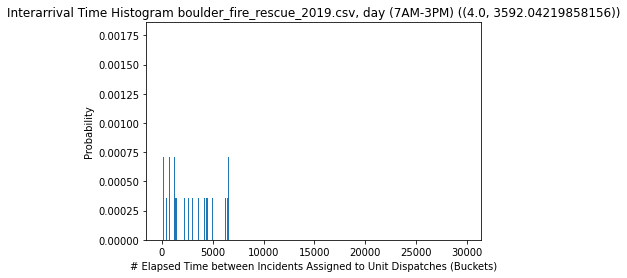

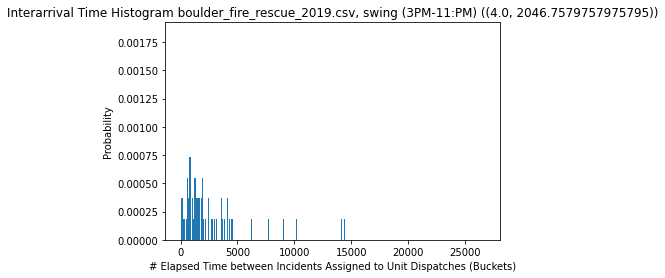

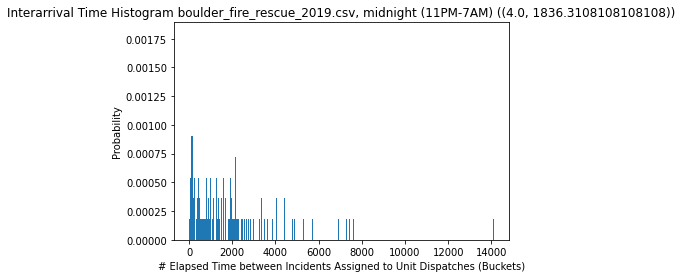

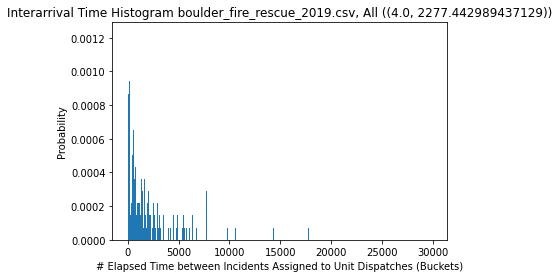

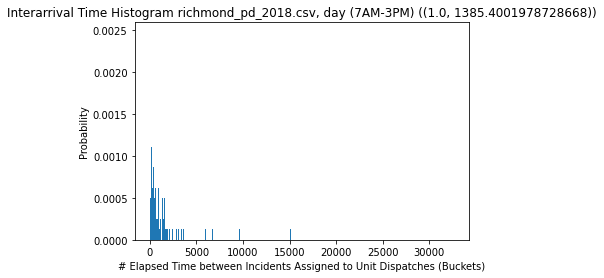

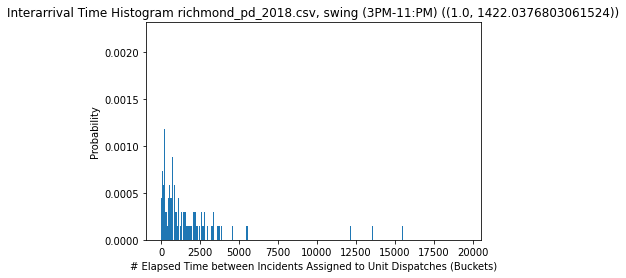

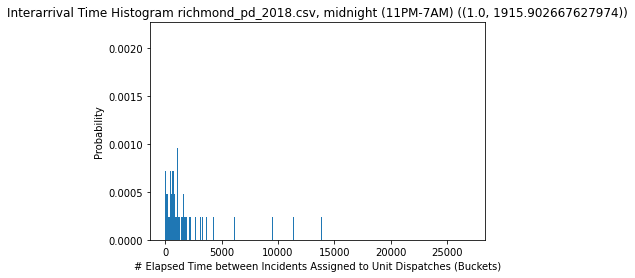

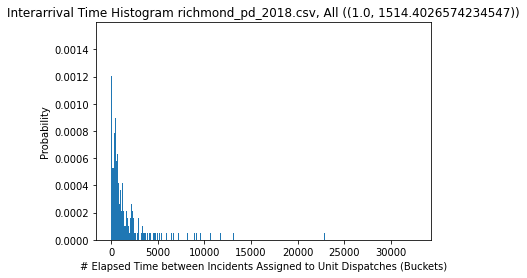

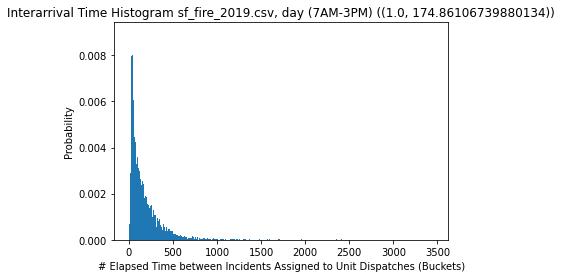

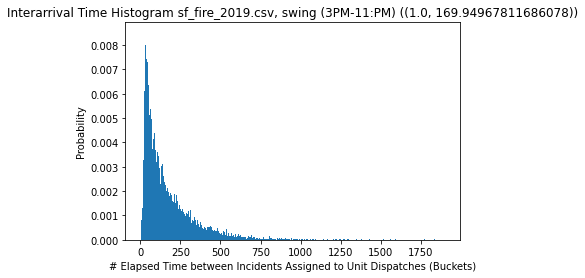

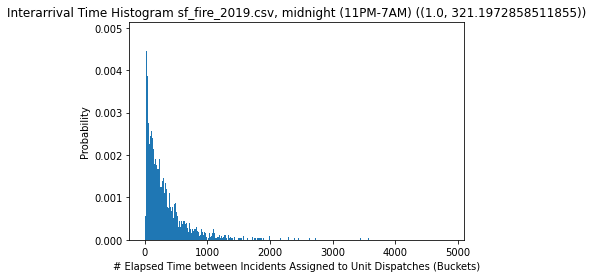

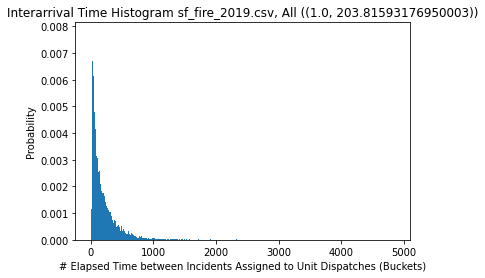

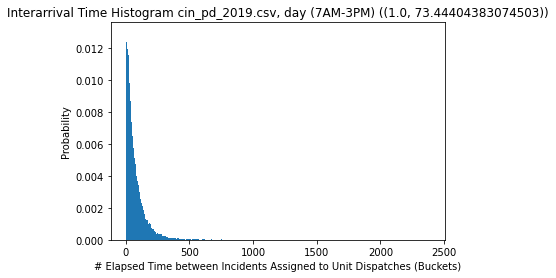

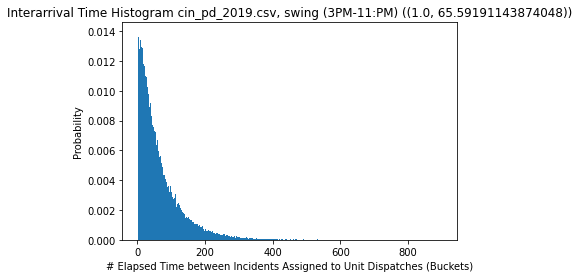

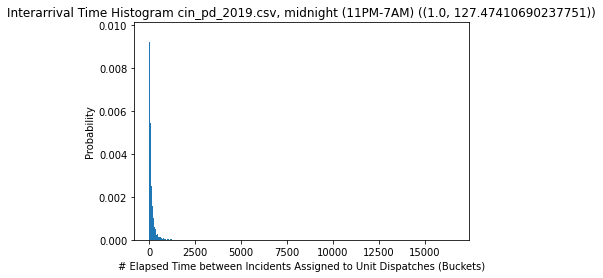

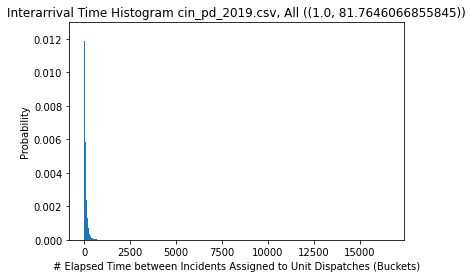

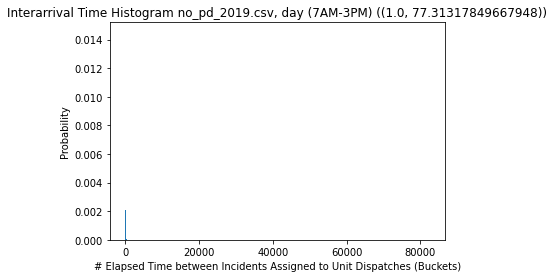

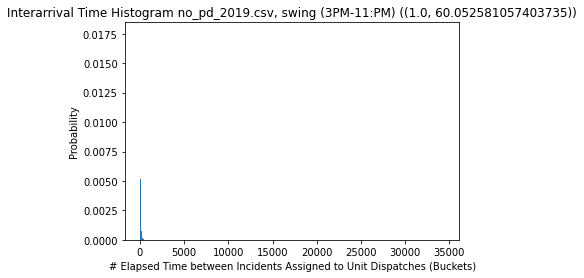

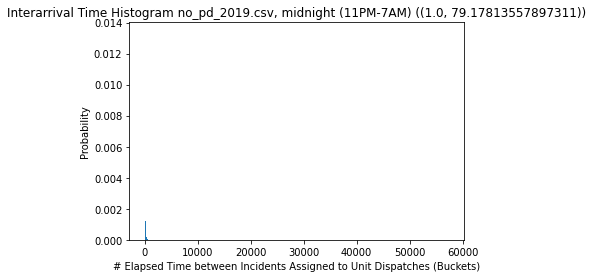

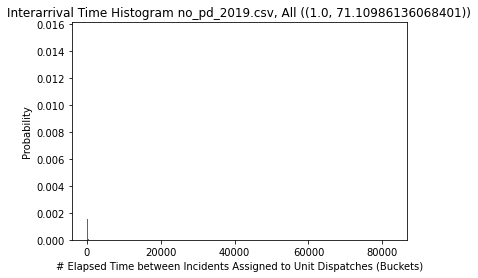

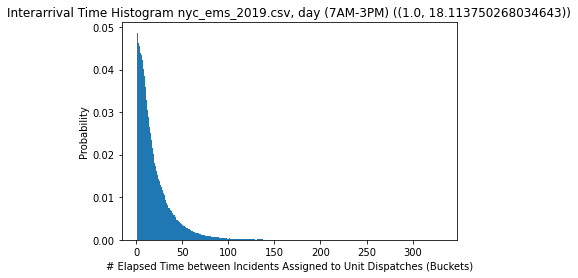

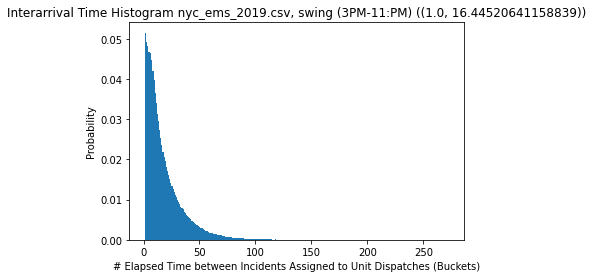

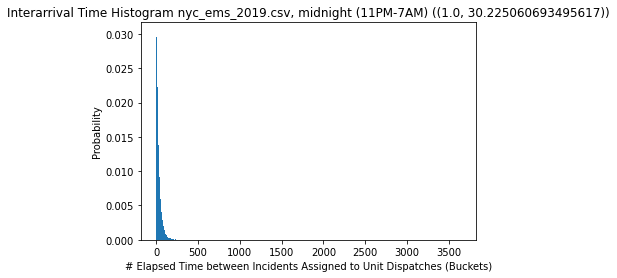

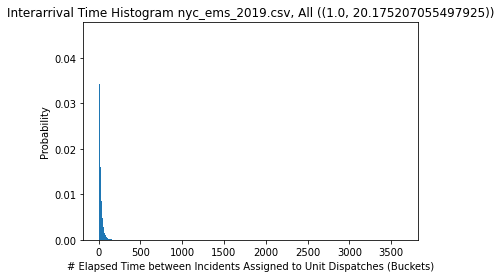

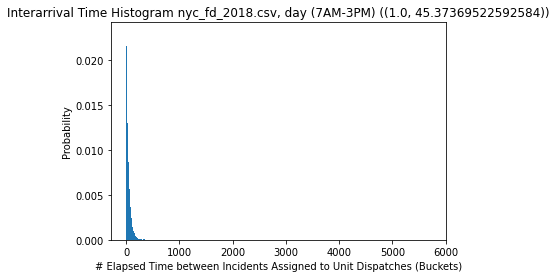

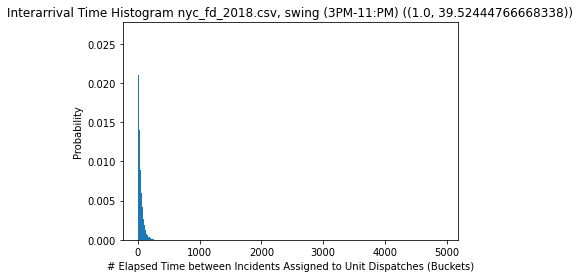

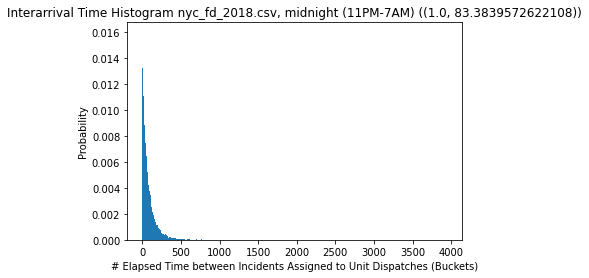

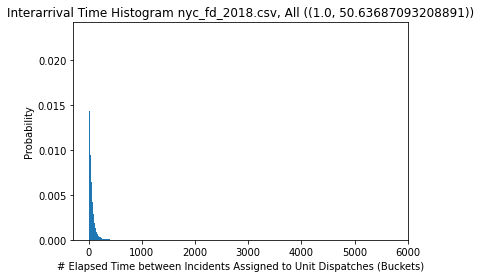

In [4]:
for name, obj in inter_arrival_map.items():
    plot_interarrival_histogram(name, obj)


/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created

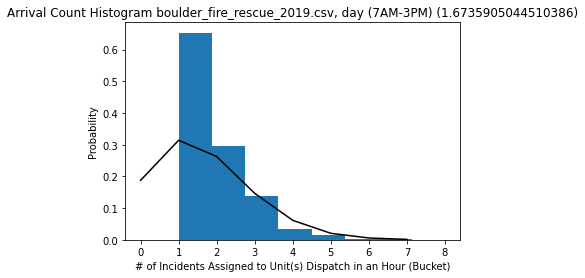

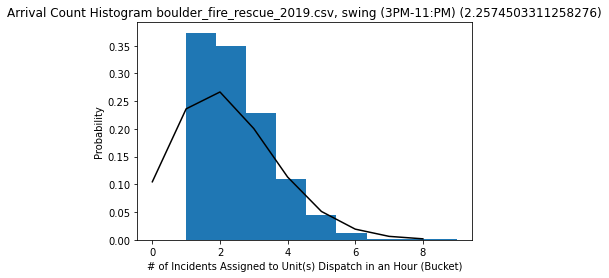

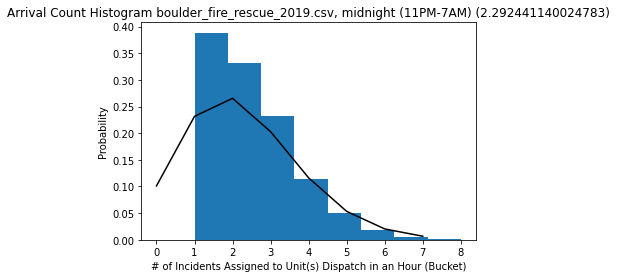

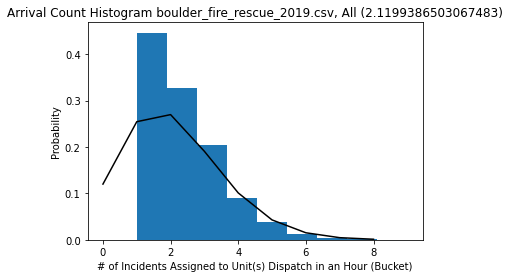

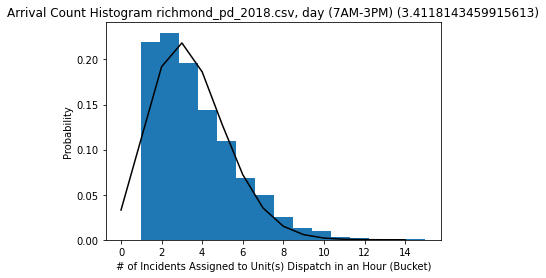

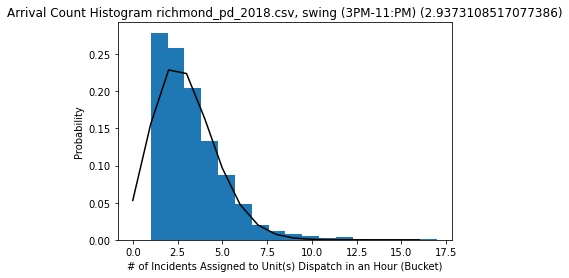

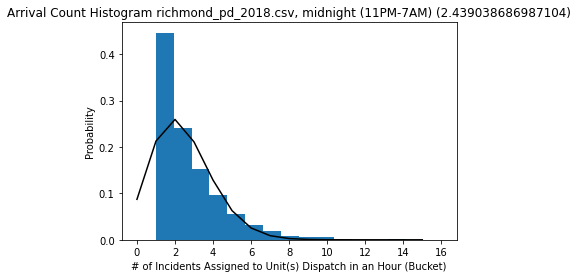

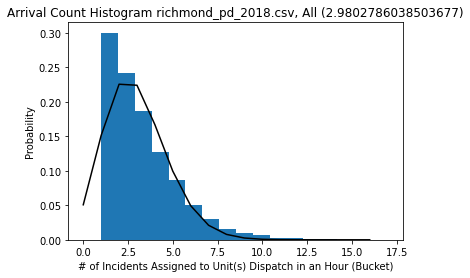

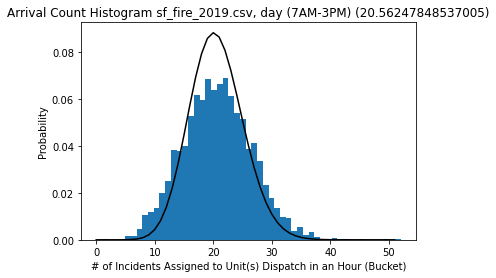

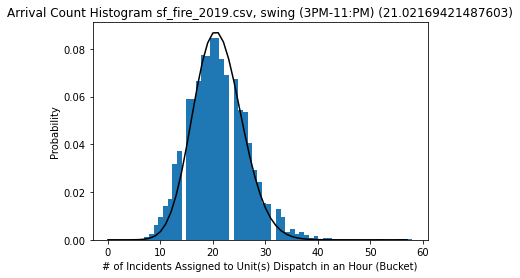

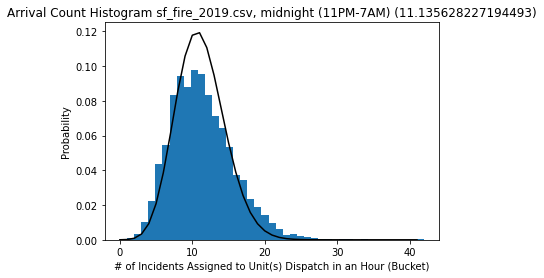

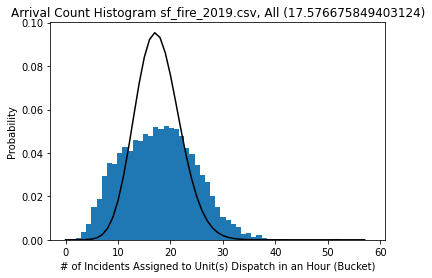

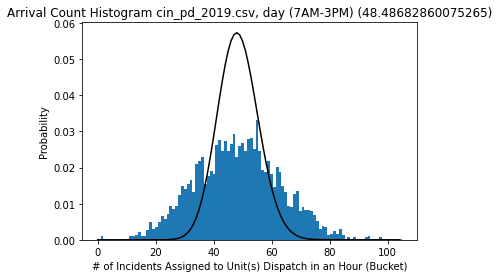

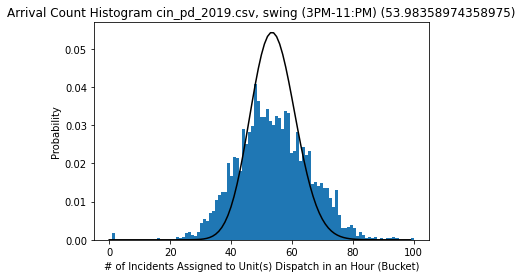

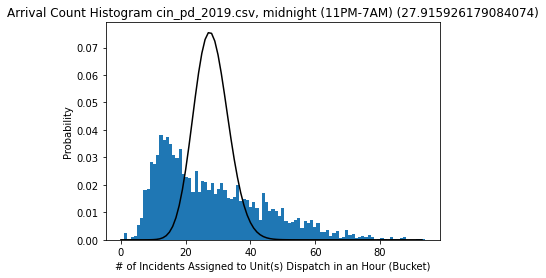

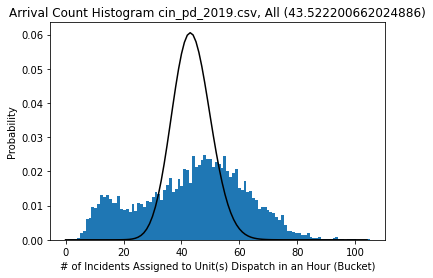

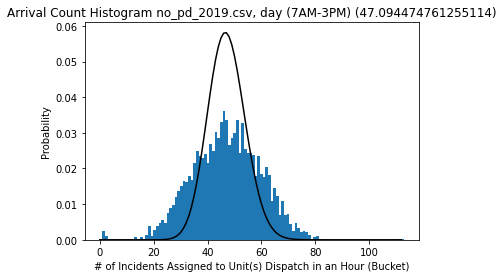

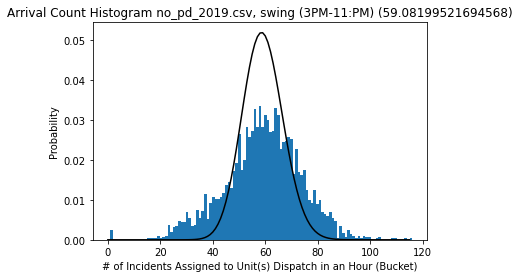

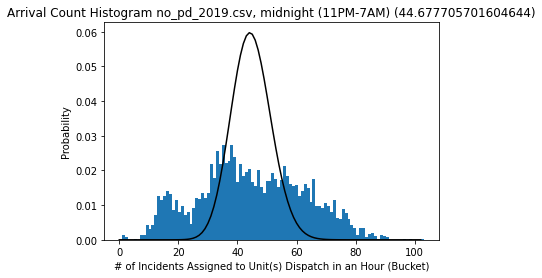

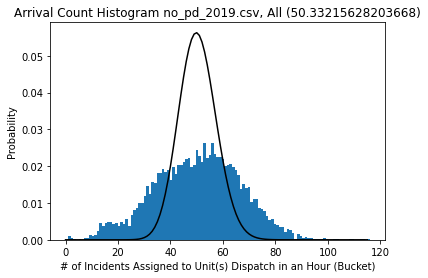

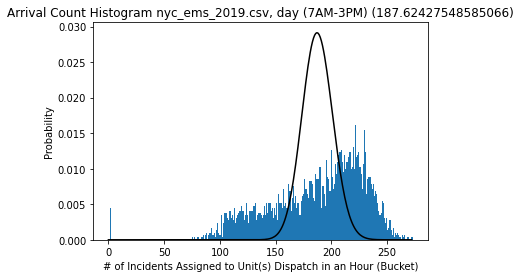

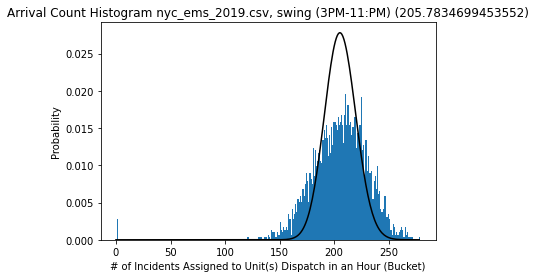

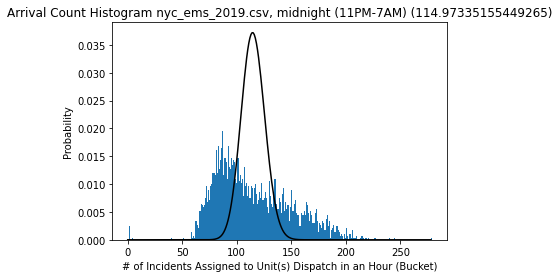

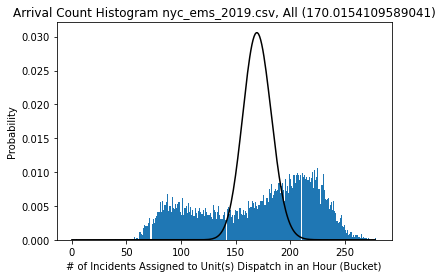

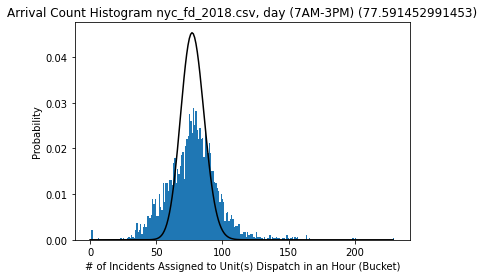

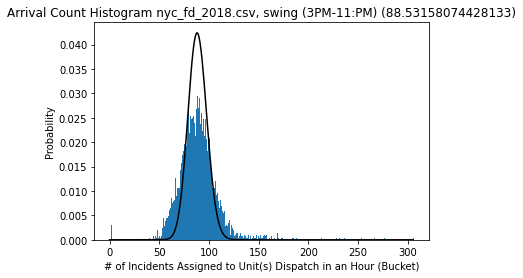

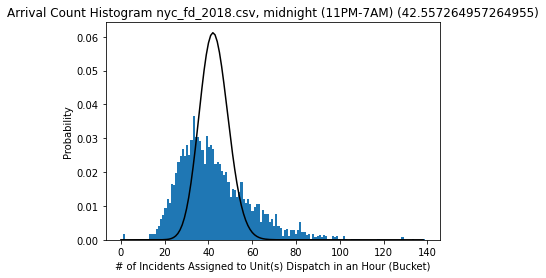

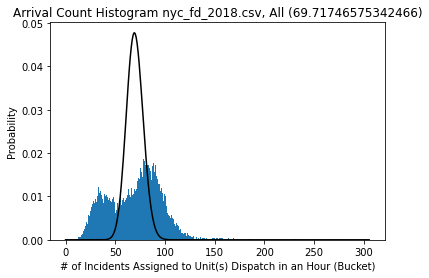

In [5]:
for name, obj in arrival_count_map.items():
    plot_arrival_histogram(name, obj)